In [10]:
import gt_sampling
import sys
import pickle
import torch
sys.path.append('../utils')

from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import utils
import numpy as np
import random

In [11]:
f_number = 24
n_dim = 2
samples = 1000	

problem_1 = utils.create_problem(f_number, n_dim, seed=42)

sample_f24 = gt_sampling.get_sample(problem_1, n_samples=samples, n_dim=2, seed=42, method='random')

X_input = torch.tensor(sample_f24[0], dtype=torch.float32).clone().detach()
X_input_grad1 = torch.tensor(np.concatenate((X_input, sample_f24[2]), axis=1), dtype=torch.float32).clone().detach()

In [12]:
FOLDER = '../models'
svm1 = pickle.loads(open(f'{FOLDER}/SVM_grad.pkl', 'rb').read())

def my_test_func(X):
    if X.dim() == 1:
        X = X[None, ...]
    return utils.test_function(X, X_input, X_input_grad1[:,2:4], svm1)

functions = [[problem_1, 'Problem_seed42'], [my_test_func, 'Problem_seed187']]

In [13]:
problem_1(torch.Tensor([[0,0]]))

tensor([-343.6118])

In [14]:
def random_search_optimization(function, n_dim, num_iterations=100, search_range=(-5.0, 5.0)):
    best_inputs = []
    best_outputs = []

    best_input = None
    best_output = float('inf')

    for _ in range(num_iterations):
        # Generate a random tensor input within the search range
        random_input = torch.rand(n_dim) * (search_range[1] - search_range[0]) + search_range[0]

        # Compute the output of the function for the random input
        output = function(random_input)

        # Check if the current output is better than the best found so far
        if output < best_output:
            best_output = output
            best_input = random_input

        # Save the best input and output at this iteration
        best_inputs.append(best_input)
        best_outputs.append(best_output.item())

    return best_inputs, best_outputs

In [15]:
def gradient_descent_optimization(function, n_dim, num_iterations=100, learning_rate=0.01, search_range=(-5.0, 5.0)):
    best_inputs = []
    best_outputs = []

    # Initialize random input tensor within the search range
    best_input = torch.rand(n_dim) * (search_range[1] - search_range[0]) + search_range[0]
    best_input.requires_grad = True  # Set requires_grad to True for autograd

    best_output = function(best_input)

    for _ in range(num_iterations):
        # Perform a forward pass to compute the output
        output = function(best_input)

        # Clear gradients from the previous iteration
        best_input.grad = None

        # Compute gradients using automatic differentiation
        output.backward()

        # Update the parameters using the computed gradients with gradient descent
        with torch.no_grad():
            best_input -= learning_rate * best_input.grad

        # Update the best output and input if needed
        if output < best_output:
            best_output = output
            best_inputs.append(best_input.detach().clone().cpu().numpy())  # Store the best input (detach to avoid gradients)
            best_outputs.append(best_output.item())

    return best_inputs, best_outputs

In [16]:
def evolutionary_optimization(function, n_dim, num_iterations=100, search_range=(-5.0, 5.0)):
    best_inputs = []
    best_outputs = []

    def callback_func(xk, convergence):
        best_inputs.append(xk)

    def wrap_function(x):
        return function(torch.Tensor(x)).item()

    result = differential_evolution(wrap_function, 
        bounds=[(-5,5), (-5,5)], 
        maxiter=num_iterations, 
        callback=callback_func, popsize=10, tol=1e-9)

    # calculate best outputs
    for i in range(len(best_inputs)):
        best_outputs.append(wrap_function(best_inputs[i]))

    return best_inputs, best_outputs    


In [17]:
def get_optimum(function):
    return function(function.x_opt).item()

In [18]:
def perform_optimization(type, function, n_dim, num_iterations):
    if type == "Random":
        return random_search_optimization(function, n_dim, num_iterations)
    elif type == "Gradient":
        return gradient_descent_optimization(function, n_dim, num_iterations)
    elif type == "Evolutionary":
        return evolutionary_optimization(function, n_dim, num_iterations)

tensor([[2.0316, 2.4589]])
tensor([241.0889, 100.7080])
(1, 4)
tensor([[2.6248, 4.7136]])
tensor([ 958.2520, 1287.8418])
(1, 4)
tensor([[-1.0860, -0.0181]])
tensor([134.2773, -70.1904])
(1, 4)
tensor([[-1.6096,  0.9442]])
tensor([-640.8691, -952.1484])
(1, 4)
tensor([[-4.8879, -0.6472]])
tensor([665.2832, 860.5957])
(1, 4)
tensor([[ 4.8597, -1.5846]])
tensor([ 27.4658, 109.8633])
(1, 4)
tensor([[-3.1052, -4.6490]])
tensor([296.0205, 653.0762])
(1, 4)
tensor([[1.4082, 1.7768]])
tensor([387.5732, 671.3867])
(1, 4)
tensor([[0.1445, 3.9061]])
tensor([-741.5771, -976.5625])
(1, 4)
tensor([[1.9199, 1.2249]])
tensor([256.3477, 350.9521])
(1, 4)
tensor([[3.3284, 2.9780]])
tensor([ 982.6660, 1187.1338])
(1, 4)
tensor([[-0.3848, -2.3430]])
tensor([-210.5713, -509.6436])
(1, 4)
tensor([[-2.6135, -3.5057]])
tensor([ 6.1035, 67.1387])
(1, 4)
tensor([[0.6985, 3.3285]])
tensor([ 73.2422, 369.2627])
(1, 4)
tensor([[-0.6077, -3.0355]])
tensor([-457.7637, -482.1777])
(1, 4)
tensor([[-2.3232, -2.5236]])


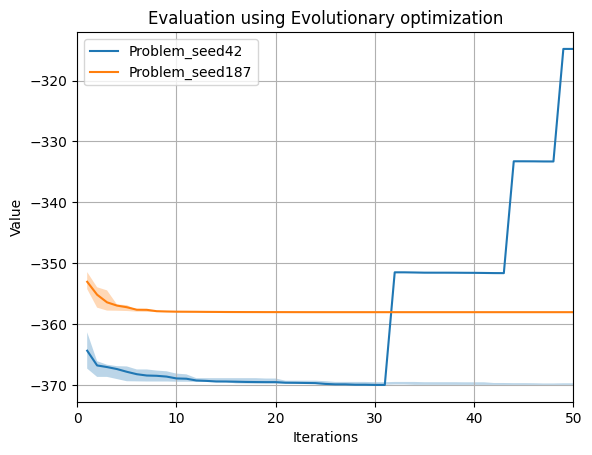

In [19]:
n_times = 20  # Number of times to repeat the random search
i_evaluations = 50  # Number of evaluations in each random search
optimization_type = "Evolutionary"

for elem in functions:

    results = []
    # optimum = get_optimum(elem[0])

    # Perform random search 'n_times' times and store the results
    for _ in range(n_times):
        best_inputs, best_outputs = perform_optimization(optimization_type, elem[0], n_dim, num_iterations=i_evaluations)
        results.append(np.array(best_outputs))

    # append the elements of results to the same length as the longest
    # Find the maximum length
    max_length = max(len(arr) for arr in results)

    # Initialize a list to store the padded arrays
    padded_array_list = []

    # Loop through the original list and pad arrays
    for arr in results:
        padding_length = max_length - len(arr)
        padded_arr = np.pad(arr, (0, padding_length), mode='constant', constant_values=0)
        padded_array_list.append(padded_arr)

    results = padded_array_list

    # Calculate the mean and interquartile range (IQR) for each evaluation
    mean_values = np.mean(results, axis=0)
    q1 = np.percentile(results, 75, axis=0) 
    q3 = np.percentile(results, 25, axis=0)

    x = [i for i in range(1, len(mean_values)+1)]

    plt.plot(x, mean_values, label=f'{elem[1]}')
    plt.fill_between(x, q1, q3,  alpha=0.3)


plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.xlim(0, len(mean_values))
plt.title(f'Evaluation using {optimization_type} optimization')
plt.grid(True)
plt.show()